# Lab 2: Transfer Learning and Transformers

**CS8321: Machine Learning & Neural Networks**<br>
**February 23, 2025**<br><br>
Xiaona Hang - I completed the part of finetuning BERT<br>


## 1. Classification Task

The dataset is used for sentiment classification of tweets, where each tweet is assigned a label indicating its sentiment:

*   0 → Negative Sentiment
*   1 → Neutral Sentiment
*   2 → Positive Sentiment

This is a supervised, multi-class classification task because each tweet is categorized into one of three distinct sentiment classes.

## 2. Business Case

The ability to classify sentiment in tweets has many business applications, including:



*   Brand Monitoring: Companies can analyze customer feedback on social media to understand public perception.
*   Customer Support: Automating sentiment analysis helps prioritize negative tweets for faster responses.
*   Market Research: Understanding user sentiment trends allows businesses to adjust marketing strategies.
*   Political & Social Analysis: Tracking sentiment on political or social issues helps policymakers and researchers gauge public opinion.

Since social media sentiment can significantly impact brand reputation and marketing success, accurate classification is crucial for decision-making.

## 3. Multi-Task Nature

*   Is this multi-task? Explain.





## 4. Feature Data


*   Text Data: Each tweet is an individual sample that serves as input to the model.
*   Label Data: Each tweet is labeled as negative (0), neutral (1), or positive (2).



## 5. Data Collection

*   Collected by: The dataset is part of TweetEval, a standardized benchmark for Twitter-specific NLP tasks.
*   Purpose: Created to provide a unified framework for evaluating NLP models on Twitter-based classification problems.
*   Time of Collection: The dataset is derived from various existing Twitter datasets, compiled into the TweetEval benchmark in 2020.
*   Data Type: Single-modal dataset (only text data, no images or other modalities).



## 6. Evaluation Criteria
What evaluation criteria will you be using and why? Why does this support the business case?

## 7. Model
[2.0 points] Describe the foundational model that you will be using to transfer learn from. What task(s) was this foundational model trained upon? Explain if the new task is within the same domain, across domains, etc.


## 8. Data Split

In [1]:
import pandas as pd
import numpy as np
import re
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/sample_data

In [3]:
# def preprocess_text(text):
#     """Basic text cleaning: lowercasing, removing special characters."""
#     text = text.lower()
#     text = re.sub(r'http\S+', '', text)  # Remove URLs
#     text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
#     return text

# data['clean_text'] = data['text'].apply(preprocess_text)

### Data Split
The TweetEval dataset provides predefined splits for training, validation, and testing. This means that instead of manually splitting the dataset, we can use the official splits prepared by the dataset authors.

The dataset was originally complied from multiple Twitter sentiment datasets and restructured as part of TweetEval.

**Key Aspects:**

*   80% Training/10% Testing/10% Validation - the model needs enough data to learn, hence the 80% for the training set. The remaining 20% is used to test and evaluate model perfomance on unseen tweets.
*   Stratification (stratify=data['label']) - ensures each sentiment class (negative, neutral, positive) is proportionally represented in both train and test sets. This also prevents the model from overfitting to dominant classes if the dataset is imbalanced.
*   Random Seed (random_seed=42) - ensures that the train-test split remains consistent across different runs.


This will allown us to evaluate how well the model performs on new, unseen tweets. If the dataset contains significantly more neutral tweets than possitive or negative ones, stratification ensures that all sentiment categories are proportionally distributed in both training and testing sets. Additionally, keeping 80% for training has become standard practice in natural language processing as many pre-trained transformers, like BERT, require large amounts of data for training.

### Why we kept the author's split vs a manual split:

*   **Consistency:** Using the same train/val/test split ensures that model comparisons are fair and reproducible.
*   **Class Balance:** The authors have already ensured that all sentiment classes are equally distributed in each subset.
*   **Prevents data leakage:** It ensures that tweets appearing in training do not overlan with the test set.
*   **Standardizes Evaluation:** Since we are using the same predefined split, model comparisons remain fair.











## 9. Baseline Model
Train a baseline model from scratch to perform the classification task. That is, do NOT use transfer learning for this step--you are training a model to see the baseline performance. Verify the model converges (even if the model is overfit). Note: This does NOT need to mirror the foundational model nor does this need to be a transformer--this model may be far less computational to train.

### **Loading Google Drive for Accessing Dataset**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/cs8321_Labs/Datasets

### **Imports Needed for this Section**

In [7]:
# Imports for Base Model/s
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
from tabulate import tabulate
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [8]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### **Track Time and Formatting Time Output**

In [9]:
# To Convert Time for Readibility
def convert_time(seconds):
    if seconds < 60:
        return f"{seconds:.2f}s"
    elif seconds < 3600:
        minutes = int(seconds // 60)
        sec = int(seconds % 60)
        return f"{minutes}min {sec}s"
    else:
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        sec = int(seconds % 60)
        return f"{hours}h {minutes}min {sec}s"

# Track computation times
training_times = {}
prediction_times = {}

### **Loading Tweets Dataset**

In [10]:
# Load the dataset
file_path = "tweetsDataset.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1", header=None, names=["target", "id", "date", "flag", "user", "text"])

display(df.head())

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### **Pre-Processing Dataset before Base Model**

In [11]:
# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    return text.lower()

df["clean_text"] = df["text"].apply(preprocess_text)
display(df.head())

,target,id,date,flag,user,text,clean_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...


### **Re-Mapping Target Labels**

In [12]:
# Convert labels to multi-class (0 = Negative, 1 = Neutral, 2 = Positive)
df["target"] = df["target"].map({0: 0, 2: 1, 4: 2})

### **Vectorizing Inputs and Splitting Dataset (70% Train, 15% Test, and 15% Validation Set)**

In [13]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["target"]

In [14]:
# Split into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### **Base Model 1: Logistic Regression**

In [15]:
# Logistic Regression
start_train = time.time()
logistic_model = LogisticRegression(max_iter=100, solver='lbfgs')
logistic_model.fit(X_train, y_train)
end_train = time.time()
training_times["Logistic Regression"] = end_train - start_train

start_pred = time.time()
logistic_val_preds = logistic_model.predict(X_val)
logistic_test_preds = logistic_model.predict(X_test)
end_pred = time.time()
prediction_times["Logistic Regression"] = end_pred - start_pred

logistic_val_acc = accuracy_score(y_val, logistic_val_preds)
logistic_test_acc = accuracy_score(y_test, logistic_test_preds)

print(f"Logistic Regression:\nValidation Accuracy: {logistic_val_acc*100:.2f}%\n"
      f"Test Accuracy: {logistic_test_acc*100:.2f}%\n"
      f"Training Time: {convert_time(training_times['Logistic Regression'])}\n"
      f"Prediction Time: {convert_time(prediction_times['Logistic Regression'])}")

Logistic Regression:
Validation Accuracy: 78.55%
Test Accuracy: 78.42%
Training Time: 1.14s
Prediction Time: 0.01s


### **Base Model 2: Decision Tree**

In [16]:
# Decision Tree
start_train = time.time()
dt_model = DecisionTreeClassifier(max_depth=10)
dt_model.fit(X_train, y_train)
end_train = time.time()
training_times["Decision Tree"] = end_train - start_train

start_pred = time.time()
dt_val_preds = dt_model.predict(X_val)
dt_test_preds = dt_model.predict(X_test)
end_pred = time.time()
prediction_times["Decision Tree"] = end_pred - start_pred

dt_val_acc = accuracy_score(y_val, dt_val_preds)
dt_test_acc = accuracy_score(y_test, dt_test_preds)

print(f"Decision Tree:\nValidation Accuracy: {dt_val_acc*100:.2f}%\n"
      f"Test Accuracy: {dt_test_acc*100:.2f}%\n"
      f"Training Time: {convert_time(training_times['Decision Tree'])}\n"
      f"Prediction Time: {convert_time(prediction_times['Decision Tree'])}")

Decision Tree:
Validation Accuracy: 61.15%
Test Accuracy: 60.96%
Training Time: 30.93s
Prediction Time: 0.08s


### **Base Model 3: Random Forest**

In [17]:
# Random Forest
start_train = time.time()
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10)
rf_model.fit(X_train, y_train)
end_train = time.time()
training_times["Random Forest"] = end_train - start_train

start_pred = time.time()
rf_val_preds = rf_model.predict(X_val)
rf_test_preds = rf_model.predict(X_test)
end_pred = time.time()
prediction_times["Random Forest"] = end_pred - start_pred

rf_val_acc = accuracy_score(y_val, rf_val_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)

print(f"Random Forest:\nValidation Accuracy: {rf_val_acc*100:.2f}%\n"
      f"Test Accuracy: {rf_test_acc*100:.2f}%\n"
      f"Training Time: {convert_time(training_times['Random Forest'])}\n"
      f"Prediction Time: {convert_time(prediction_times['Random Forest'])}")

Random Forest:
Validation Accuracy: 70.31%
Test Accuracy: 70.27%
Training Time: 27.99s
Prediction Time: 0.84s


### **Base Model 4: Neural Network (MLP)**

In [18]:
# Neural Network (MLP)
start_train = time.time()
mlp_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=80, warm_start=True)
mlp_model.fit(X_train, y_train)
end_train = time.time()
training_times["Neural Network (MLP)"] = end_train - start_train

start_pred = time.time()
mlp_val_preds = mlp_model.predict(X_val)
mlp_test_preds = mlp_model.predict(X_test)
end_pred = time.time()
prediction_times["Neural Network (MLP)"] = end_pred - start_pred

mlp_val_acc = accuracy_score(y_val, mlp_val_preds)
mlp_test_acc = accuracy_score(y_test, mlp_test_preds)

print(f"Neural Network (MLP):\nValidation Accuracy: {mlp_val_acc*100:.2f}%\n"
      f"Test Accuracy: {mlp_test_acc*100:.2f}%\n"
      f"Training Time: {convert_time(training_times['Neural Network (MLP)'])}\n"
      f"Prediction Time: {convert_time(prediction_times['Neural Network (MLP)'])}")

Neural Network (MLP):
Validation Accuracy: 79.52%
Test Accuracy: 79.44%
Training Time: 3min 40s
Prediction Time: 0.05s


### **Visualizing Models Performance**

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results():
    models = list(training_times.keys())
    val_accuracies = [logistic_val_acc, rf_val_acc, dt_val_acc, mlp_val_acc]
    test_accuracies = [logistic_test_acc, rf_test_acc, dt_test_acc, mlp_test_acc]
    train_times = [training_times[m] for m in models]
    pred_times = [prediction_times[m] for m in models]

    bar_width = 0.35  # Adjust width for side-by-side bars
    x = np.arange(len(models))  # Create index positions for models

    plt.figure(figsize=(18,5))

    # Accuracy Plot
    plt.subplot(1,3,1)
    plt.bar(x - bar_width/2, val_accuracies, width=bar_width, color='blue', label="Validation Accuracy")
    plt.bar(x + bar_width/2, test_accuracies, width=bar_width, color='orange', label="Test Accuracy")
    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.title("Validation vs Test Accuracy")
    plt.xticks(x, models, rotation=45)
    plt.legend()

    # Computational Time Plot
    plt.subplot(1,3,2)
    plt.bar(x - bar_width/2, train_times, width=bar_width, color='red', label="Training Time (s)")
    plt.bar(x + bar_width/2, pred_times, width=bar_width, color='green', label="Prediction Time (s)")
    plt.xlabel("Models")
    plt.ylabel("Time (seconds)")
    plt.title("Training & Prediction Time per Model")
    plt.xticks(x, models, rotation=45)
    plt.legend()

    # Loss Curve for Neural Network (MLP)
    plt.subplot(1,3,3)
    if hasattr(mlp_model, "loss_curve_"):
        plt.plot(mlp_model.loss_curve_, label="Training Loss", color='purple')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Neural Network Loss Curve")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No Loss Curve Available", fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

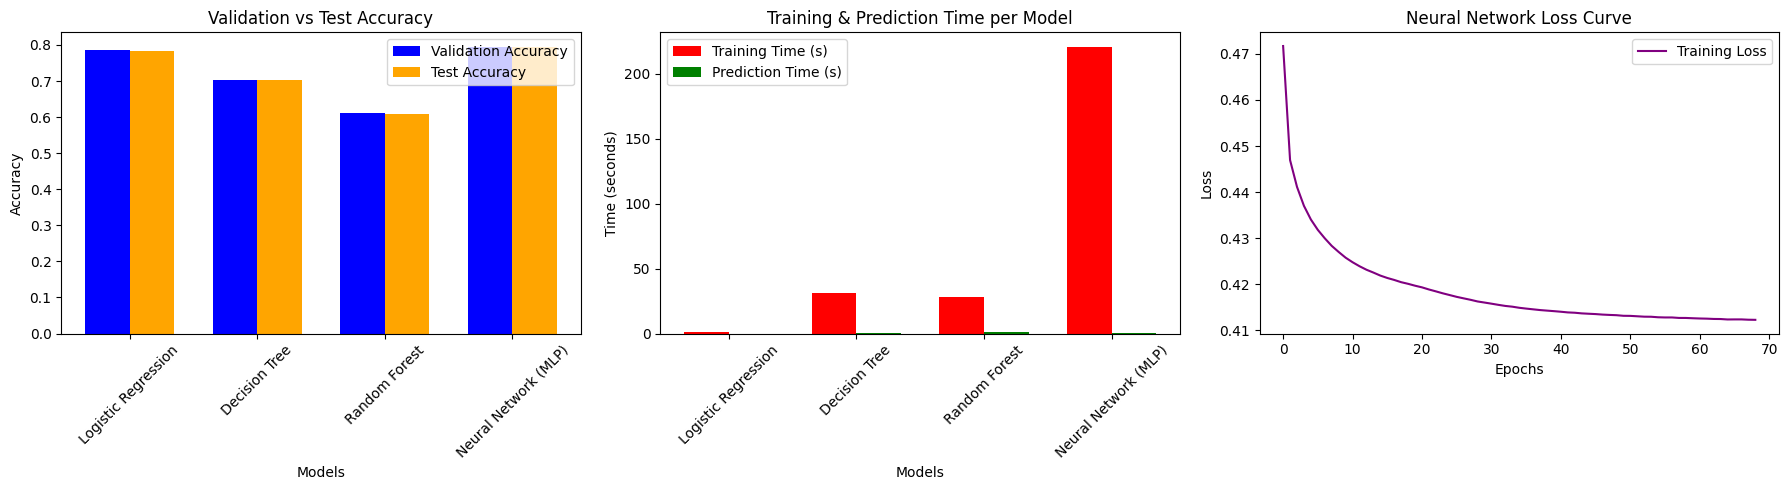

In [20]:
plot_results()

### **Summary of Base Models and Best Performance**

In [ ]:
def summarize_results():
    results_df = pd.DataFrame({
        "Model": list(training_times.keys()),
        "Validation Accuracy (%)": [logistic_val_acc*100, rf_val_acc*100, dt_val_acc*100, mlp_val_acc*100],
        "Test Accuracy (%)": [logistic_test_acc*100, rf_test_acc*100, dt_test_acc*100, mlp_test_acc*100],
        "Training Time": [convert_time(training_times[m]) for m in training_times],
        "Prediction Time": [convert_time(prediction_times[m]) for m in prediction_times]
    })

    # Highlight the best performing model based on test accuracy
    best_model_idx = results_df["Test Accuracy (%)"].idxmax()
    results_df.loc[best_model_idx, "Best Model"] = "✅ Best Performance"

    # Print the table in a well-formatted way using tabulate
    print("\ Model Performance Summary:")
    print(tabulate(results_df, headers="keys", tablefmt="pretty", showindex=False))

In [22]:
summarize_results()


📊 Model Performance Summary:
+----------------------+-------------------------+--------------------+---------------+-----------------+---------------------+
|        Model         | Validation Accuracy (%) | Test Accuracy (%)  | Training Time | Prediction Time |     Best Model      |
+----------------------+-------------------------+--------------------+---------------+-----------------+---------------------+
| Logistic Regression  |         78.5475         |       78.425       |     1.14s     |      0.01s      |         nan         |
|    Decision Tree     |    70.31166666666667    | 70.26708333333333  |    30.93s     |      0.08s      |         nan         |
|    Random Forest     |    61.14833333333334    | 60.955000000000005 |    27.99s     |      0.84s      |         nan         |
| Neural Network (MLP) |        79.52125         | 79.44458333333333  |   3min 40s    |      0.05s      | ✅ Best Performance |
+----------------------+-------------------------+--------------------+----

## 11. Fine tuning Model
[2.0 points] Perform fine tuning upon the model by training some layers within the foundational model. Verify that the model converges.

In [23]:
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
from tabulate import tabulate
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [24]:

file_path = "tweetsDataset.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1", header=None, names=["target", "id", "date", "flag", "user", "text"])
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    return text.lower()
df["clean_text"] = df["text"].apply(preprocess_text)
df.head()

,target,id,date,flag,user,text,clean_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...


In [25]:
df["target"].unique()

array([0, 4], dtype=int64)

<Axes: >

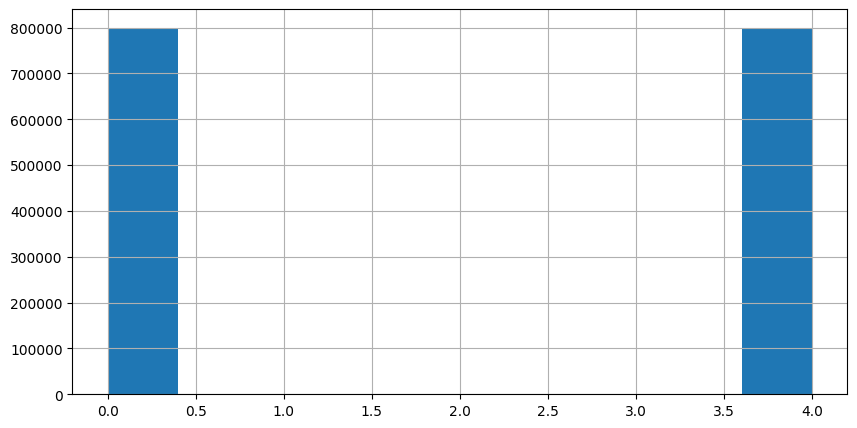

In [26]:
# distribution of target class
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
df['target'].hist(ax=ax)


In [27]:
# Convert labels to multi-class (0 = Negative, 1 = Neutral, 2 = Positive)
df["target"] = df["target"].map({0: 0, 2: 1, 4: 2})

<Axes: >

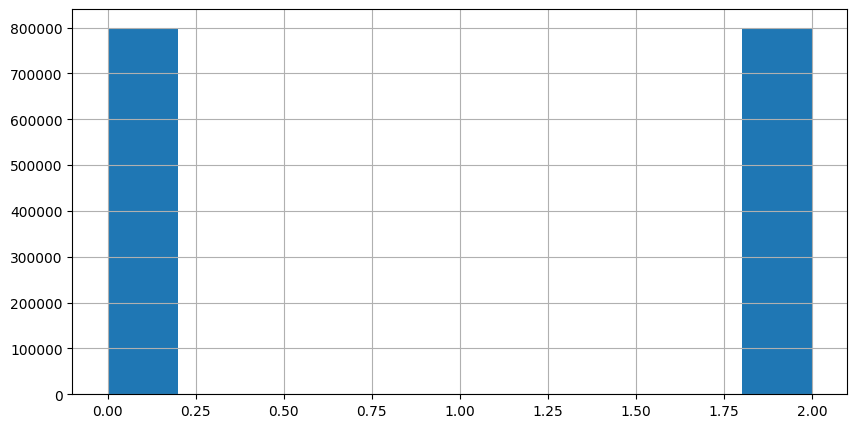

In [28]:
# distribution of target classa after reassignment
fig = plt.figure(figsize = (10,5))
ax = fig.gca() # get current axis
df['target'].hist(ax=ax)

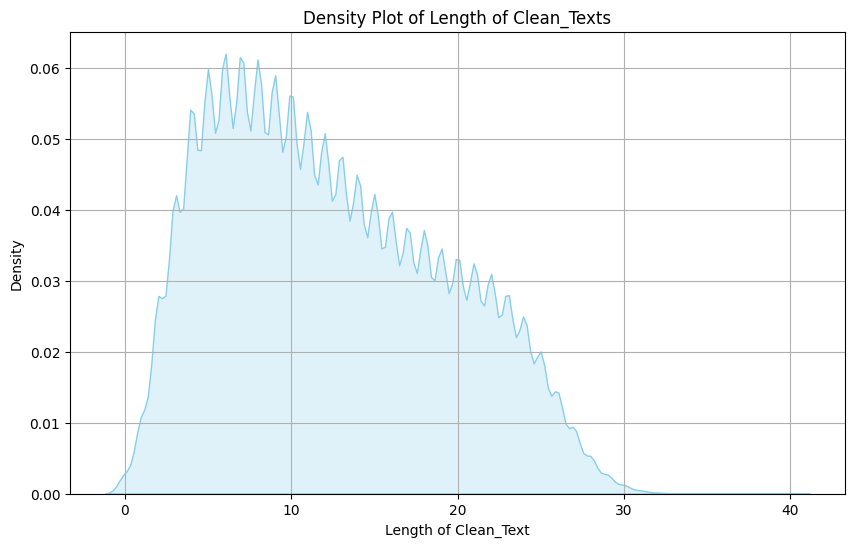

Max length: 40
Min length: 0
Mean length: 12.354689375


In [29]:
import seaborn as sns

clean_text_lengths = [len(clean_text.split()) for clean_text in df['clean_text']]

plt.figure(figsize=(10, 6))
sns.kdeplot(clean_text_lengths, fill=True, color='skyblue')
plt.xlabel('Length of Clean_Text')
plt.ylabel('Density')
plt.title('Density Plot of Length of Clean_Texts')
plt.grid(True)
plt.show()

print(f'Max length: {max(clean_text_lengths)}')
print(f'Min length: {min(clean_text_lengths)}')
print(f'Mean length: {sum(clean_text_lengths) / len(clean_text_lengths)}')

Since the Mean of the Sequence Length is only about 12 tokens and the Max Length of 40 is not so big, we will use set max_seq_length = 40 to avoid most long sequences are not truncated unnecessarily

### **Loading and Tuning BERT**

**Step 1:** Freeze entire base model
- **Add a new layer** - When loading BERT Model, add on a new, untrained, and fully connected layer with 3 outputs, as it determines the mumber of output classes for classification:

  - 0 → Negative Sentiment
  - 1 → Neutral Sentiment
  - 2 → Positive Sentiment

  In the below loading, we explicitly don't load the hidden layers as outputs. Only the output layer of the model setting with 3 classes are exposed.


In [30]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments



# Load a pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      output_hidden_states=False
                                                     )
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

c:\Users\seren\OneDrive\SMU\CS8321MLandNeuralNetworks\Labs\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\seren\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [31]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [32]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Since the full dataset consists of 1,600,000 samples, fine-tuning BERT on my machine would take several days. To speed up the process while maintaining a representative subset, I will randomly sample 160,000 examples.

In [33]:
import pandas as pd
subset_size = 160000  # New dataset size
df = df.groupby("target").sample(n=subset_size // df["target"].nunique(), random_state=42)
df = df.reset_index(drop=True)
print(df.shape)




(160000, 7)


In [34]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "None")


PyTorch Version: 2.6.0+cu118
CUDA Available: True
CUDA Version: 11.8
GPU Name: NVIDIA GeForce RTX 4060
Current Device: 0


In [35]:
# Check an example
example = df.clean_text[0]
encoded_input = tokenizer(example, return_tensors='pt') # pt is the PyTorch model
# send to GPU
print(f"Number of words in text: {len(example.split(' '))}, Number of tokens: {len(encoded_input.input_ids[0])}")

print(encoded_input)
print(example)

Number of words in text: 11, Number of tokens: 12
{'input_ids': tensor([[ 101, 2821, 2053, 2073, 2106, 1057, 2344, 2013, 2008, 2015, 9202,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
 oh no where did u order from thats horrible 


In [36]:
example = df.clean_text[0]
encoded_input = tokenizer(example, return_tensors='pt') # pt is the PyTorch model
# send to GPU

for k in encoded_input.keys():
    encoded_input[k] = encoded_input[k].to(device)
# get model output
output = model(**encoded_input)
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.3958, -0.0606, -0.1111]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


Send training dataset through base model and save out bottleneck features

In [37]:
# Use BERT Embeddings to tokenize the proprocessed tweet dataset

from tqdm import tqdm, trange
max_seq_length = 40
encoded_dataset = []
samples_processed = 0
for clean_text, target in tqdm(zip(df['clean_text'], df['target']), desc="Encoding", total=len(df.target)):
    encoded_example = tokenizer(clean_text, return_tensors='pt',
                                max_length=max_seq_length,
                                padding='max_length',
                                truncation=True)

    # add one more dictionary entry for the label
    encoded_example['label_id'] = target
    assert len(encoded_example.input_ids[0]) == max_seq_length
    encoded_dataset.append(encoded_example)




Encoding: 100%|██████████| 160000/160000 [00:36<00:00, 4388.57it/s]


In [38]:
print(f'Encoded dataset length: {len(encoded_dataset)}, save encoded dataset with the following fields: {encoded_dataset[0].keys()}')

Encoded dataset length: 160000, save encoded dataset with the following fields: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label_id'])


In [39]:
# import torch

# # Save the encoded dataset to a file so we don't need to run the BERT Tokenizer repeatedly - save runing time
# torch.save(encoded_dataset, 'encoded_tweets_dataset.pt')

# # Later, to load the encoded dataset:
# # encoded_dataset = torch.load('encoded_tweets_dataset.pt')


In [40]:
# combine the tensors in the next cell
tmp = torch.cat([d.input_ids for d in encoded_dataset], dim=0)
print(f'tmp shape: {tmp.shape}')
tmp

tmp shape: torch.Size([160000, 40])


tensor([[  101,  2821,  2053,  ...,     0,     0,     0],
        [  101,  1037,  2307,  ...,     0,     0,     0],
        [  101,  2157,  2125,  ...,     0,     0,     0],
        ...,
        [  101, 11688, 10047,  ...,     0,     0,     0],
        [  101,  2012, 21318,  ...,     0,     0,     0],
        [  101,  2018,  2061,  ...,     0,     0,     0]])

In [41]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data import random_split

BATCH_SIZE = 16
TRAIN_PERC = 0.8 # want 80% for training

total_len = len(df.target)
train_size = int(TRAIN_PERC*total_len) # number of docs to get to train percentage
eval_size = total_len - train_size # and remainder for evaluation

# Need to create dataset from 'input_ids', 'token_type_ids', 'attention_mask', 'label_id'
# concatenate the tensors to make one large tensor (each row is a document)
all_data = TensorDataset(torch.cat([d.input_ids for d in encoded_dataset], dim=0),
                           torch.cat([d.attention_mask for d in encoded_dataset], dim=0),
                           torch.cat([d.token_type_ids for d in encoded_dataset], dim=0),
                           torch.tensor([d.label_id for d in encoded_dataset], dtype=torch.long)
                          )

train_data, eval_data = random_split(all_data, [train_size, eval_size])

# sample at random from these tensors and setup a loader to loop through the model
train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

eval_sampler = SequentialSampler(eval_data)
# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)
eval_dataloader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Created two datasets training/eval. Training samples: {train_size}, Evaluation: {eval_size}")

# free up some memory, already saved in the new dataset
del encoded_dataset


Created two datasets training/eval. Training samples: 128000, Evaluation: 32000


**Step 2: Train BERT**
 - Train bottleneck features in new task
 - Typically 5-10 epochs is sufficient as it's easy to overfit
 - Larger Training step size is suggested

In [42]:
from torch.nn import CrossEntropyLoss
from transformers import DataCollatorWithPadding

# #Use DataCollatorWithPadding instead of manually handling padding.
# data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")
# train_dataloader = DataLoader(train_data, batch_size=16, collate_fn=data_collator)
# eval_dataloader = DataLoader(eval_data, batch_size=16, collate_fn=data_collator)

# grab one batch
batch = next(iter(train_dataloader))
input_ids, attention_mask, token_type_ids, labels = batch

# Send them to GPU/CPU device:
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
token_type_ids = token_type_ids.to(device)
labels = labels.to(device)

# Forward pass:
output = model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    token_type_ids=token_type_ids,
    labels=labels
)

print(f"There are {len(output.logits)} samples in the batch, each of size {len(output.logits[0])}")
print(f"The total loss value is {output.loss}")


There are 16 samples in the batch, each of size 3
The total loss value is 1.1788756847381592


 **On current fine-tune step, we will only unfreeze two layers.** Train:
 - the final layer of BERT, the 'classifier'
 - the pooler   

Afterward, verify that the model converges by 2 epochs.

In [43]:
# Setup some tracking
history = {}
history['train_loss'] = []
history['val_loss'] = []

from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler

TOTAL_EPOCHS = 2 # small number of epochs here in to classifier and pooler working together

# Only train the final layer of BERT
for param in model.bert.parameters():
    param.requires_grad = False

# only train the parameters for pooler and the classifier
for param in model.bert.pooler.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

train_params = list(model.bert.pooler.parameters()) + list(model.classifier.parameters())

# Tell the optimizer to only optimize these parameters in the model
optimizer = Adam(train_params)


In [44]:
from torch.amp import autocast, GradScaler
import time

scaler = GradScaler(device="cuda")

with trange(TOTAL_EPOCHS, desc="Epoch") as pbar:
    for epoch in pbar:
        model.train()
        total_loss = 0.0

        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Training {epoch}", total=int(train_size/BATCH_SIZE)+1, leave=False)):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, token_type_ids, labels = batch
            optimizer.zero_grad()

            with autocast(device_type="cuda", dtype=torch.float16):
                output = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    labels=labels
                )
                loss = output.loss

            # Use GradScaler for stable FP16 training
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track training loss
            total_loss += loss.item() * BATCH_SIZE
            pbar.set_postfix(train_loss=f"{total_loss / ((batch_idx + 1) * BATCH_SIZE):.4f}")
            pbar.refresh()

            # Free GPU memory every 5 batches
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache()

        total_loss = total_loss / train_size
        history['train_loss'].append(total_loss)

        # Evaluation Phase
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc=f"Evaluating {epoch}", total=int(eval_size/BATCH_SIZE)+1, leave=False):
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, token_type_ids, labels = batch
                output = model(
                    input_ids,
                    attention_mask,
                    token_type_ids,
                    labels=labels
                )
                total_loss += output.loss.item() * BATCH_SIZE

            # Calculate validation loss
            total_loss = total_loss / eval_size
            history['val_loss'].append(total_loss)
        pbar.set_postfix(loss=f"{total_loss:.2f}")


Epoch: 100%|██████████| 2/2 [05:11<00:00, 155.89s/it, loss=0.47]        


In [61]:
oldGPU_traintime="39m 16s"
Latest_GPU_NVIDIA_GeForce_RTX_4060_traintime="5m 11.7s"

In [46]:
all_preds = []
all_labels = []

model.eval() # set model to evaluation mode (no dropout, etc.)

# run evaluation without tracking gradient operations
with torch.no_grad():
  for batch in tqdm(eval_dataloader, desc="Evaluating", total=int(eval_size/BATCH_SIZE)+1):
      batch = tuple(t.to(device) for t in batch) # send to GPU
      input_ids, attention_mask, token_type_ids, labels = batch
      output = model(
            input_ids,
            attention_mask,
            token_type_ids,
            labels=labels)

      # Save these model outputs ad numpy arrays:
        # 1. detach the tensors from the computation graph
        # 2. copy the tensor over to the cpu (from the GPU)
        # 3. then convert to numpy
        # 4. save this numpy vector in a list of other vectors
        # stack the vectors from the list into one big numpy vector later
      all_preds.append(output.logits.detach().cpu().numpy())
      all_labels.append(labels.cpu().numpy())


Evaluating: 100%|█████████▉| 2000/2001 [00:39<00:00, 50.17it/s]


In next step:  verify that the model converges


Accuracy: 0.77


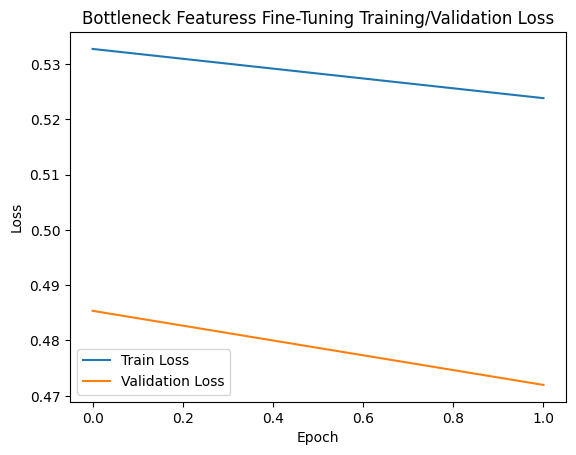

In [47]:
from sklearn.metrics import accuracy_score

# Combine the individual batched outputs and argmax for the predictions

# stack lable array into vector of class index [0, 1, 2, 3.]
labels_array = np.hstack(all_labels)
# stack each prediction into matrix where row=[net outpu array] and col=[each class probaability]
# take argmax across each network output to collapse these into a vector of int classes [1, 2,..]
preds_array = np.argmax(np.vstack(all_preds), axis=1)

# combine the preds and labels and compare with sklearn metrics
print(f"Accuracy: {accuracy_score(labels_array, preds_array):.2f}")

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bottleneck Featuress Fine-Tuning Training/Validation Loss')
plt.legend()
plt.show()


## 10. Transfer Learning Model


**Rinse and Repeat unfreeing more layers from BERT base model**
- Unfreeze one additional layer, beside the output classifer and pooler layers

In [48]:
# access the final layer of BERT, before the pooler
# we will use only the final pooling layer
model.bert.encoder.layer[-1]


BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [49]:

TOTAL_EPOCHS = 20

# unfreeze additonal weights for fine tuning
for param in model.parameters():
    param.requires_grad = False

# for param in model.bert.encoder.layer[-2].parameters():
#     param.requires_grad = True

for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

for param in model.bert.pooler.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True


train_params = list(model.classifier.parameters()) + list(model.bert.pooler.parameters()) + list(model.bert.encoder.layer[-1].parameters())

# Set optimizer to optimize these parameters with given weight decay
optimizer = Adam(train_params)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=0.001, total_iters = TOTAL_EPOCHS)


from torch.amp import autocast, GradScaler
import time

scaler = GradScaler(device="cuda")

with trange(TOTAL_EPOCHS, desc="Epoch") as pbar:
    for epoch in pbar:
        model.train()
        total_loss = 0.0

        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Training {epoch}", total=int(train_size/BATCH_SIZE)+1, leave=False)):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, token_type_ids, labels = batch
            optimizer.zero_grad()

            with autocast(device_type="cuda", dtype=torch.float16):
                output = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    labels=labels
                )
                loss = output.loss

            # Use GradScaler for stable FP16 training
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track training loss
            total_loss += loss.item() * BATCH_SIZE
            pbar.set_postfix(train_loss=f"{total_loss / ((batch_idx + 1) * BATCH_SIZE):.4f}")
            pbar.refresh()

            # Free GPU memory every 5 batches
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache()

        total_loss = total_loss / train_size
        history['train_loss'].append(total_loss)

          # reduce the LR between epochs
        scheduler.step()

        # Evaluation Phase
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc=f"Evaluating {epoch}", total=int(eval_size/BATCH_SIZE)+1, leave=False):
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, token_type_ids, labels = batch
                output = model(
                    input_ids,
                    attention_mask,
                    token_type_ids,
                    labels=labels
                )
                total_loss += output.loss.item() * BATCH_SIZE

            # Calculate validation loss
            total_loss = total_loss / eval_size
            history['val_loss'].append(total_loss)
        pbar.set_postfix(loss=f"{total_loss:.2f}")



Epoch: 100%|██████████| 20/20 [1:00:36<00:00, 181.81s/it, loss=0.42]      


In [ ]:
OldGPU_traintime_unfree_one_more_layer = "951m 16.5s"
Latest_GPU_NVIDIA_GeForce_RTX_4060_unfree_one_more_layer = "60m 36.2s"

In [51]:
model.save_pretrained("bert-finetuned-unfreeze-one-more-layer")
tokenizer.save_pretrained("bert-finetuned-unfreeze-one-more-layer")

# from transformers import BertTokenizer, BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained("bert-finetuned-unfreeze-one-more-layer")
# tokenizer = BertTokenizer.from_pretrained("bert-finetuned-unfreeze-one-more-layer")

('bert-finetuned-unfreeze-one-more-layer\\tokenizer_config.json',
 'bert-finetuned-unfreeze-one-more-layer\\special_tokens_map.json',
 'bert-finetuned-unfreeze-one-more-layer\\vocab.txt',
 'bert-finetuned-unfreeze-one-more-layer\\added_tokens.json')

In [52]:
all_preds = []
all_labels = []

model.eval() # set model to evaluation mode (no dropout, etc.)

# run evaluation without tracking gradient operations
with torch.no_grad():
  for batch in tqdm(eval_dataloader, desc="Evaluating", total=int(eval_size/BATCH_SIZE)+1):

      batch = tuple(t.to(device) for t in batch) # send to GPU
      input_ids, attention_mask, token_type_ids, labels = batch

      output = model(
            input_ids,
            attention_mask,
            token_type_ids,
            labels=labels)

      # Save these model outputs ad numpy arrays
      all_preds.append(output.logits.detach().cpu().numpy())
      all_labels.append(labels.cpu().numpy())


Evaluating: 100%|█████████▉| 2000/2001 [00:40<00:00, 49.92it/s]


In [53]:
import torch

model.eval()  # Set model to evaluation mode

# Function to extract embeddings
def extract_embeddings(dataloader, model, device):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids, label = [t.to(device) for t in batch]
            output = model.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            last_hidden_states = output.last_hidden_state  # Get last hidden states
            pooler_output = output.pooler_output  # Get pooled output (sentence-level embedding)

            embeddings.append(pooler_output.cpu())  # Store only pooled output
            labels.append(label.cpu())

    return torch.cat(embeddings), torch.cat(labels)

# Extract embeddings from train & eval datasets
train_embeddings, train_labels = extract_embeddings(train_dataloader, model, device)
eval_embeddings, eval_labels = extract_embeddings(eval_dataloader, model, device)

# Save embeddings
torch.save({"embeddings": train_embeddings, "labels": train_labels}, "train_embeddings_unfreezed_1more_layer.pt")
torch.save({"embeddings": eval_embeddings, "labels": eval_labels}, "eval_embeddings_unfreezed_1more_layer.pt")


0.81628125


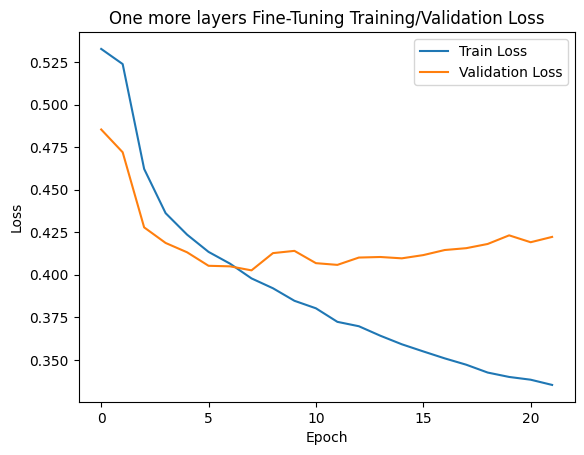

In [54]:
labels_array = np.hstack(all_labels)
preds_array = np.argmax(np.vstack(all_preds), axis=1)
print(accuracy_score(labels_array, preds_array))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('One more layers Fine-Tuning Training/Validation Loss')
plt.legend()
plt.show()




In [55]:
import pandas as pd
import matplotlib.pyplot as plt

training_results = {
    "Model": ["BERT-FineTuning-Classifier-Pooler-BottleNeck", "BERT-FineTuning-Classifier-Pooler-Unfreeze-One-More-Layer"],
    "Epochs": [2, 20],
    "Training Time (minutes)": [39 + 16/60, 951 + 16.5/60],  # Convert time to minutes
    "Accuracy": [0.76, 0.81453125]
}

df_results_BERT_FineTuning = pd.DataFrame(training_results)

In [56]:
df_results_BERT_FineTuning

,Model,Epochs,Training Time (minutes),Accuracy
0,BERT-FineTuning-Classifier-Pooler-BottleNeck,2,39.266667,0.760000
1,BERT-FineTuning-Classifier-Pooler-Unfreeze-One...,20,951.275000,0.814531


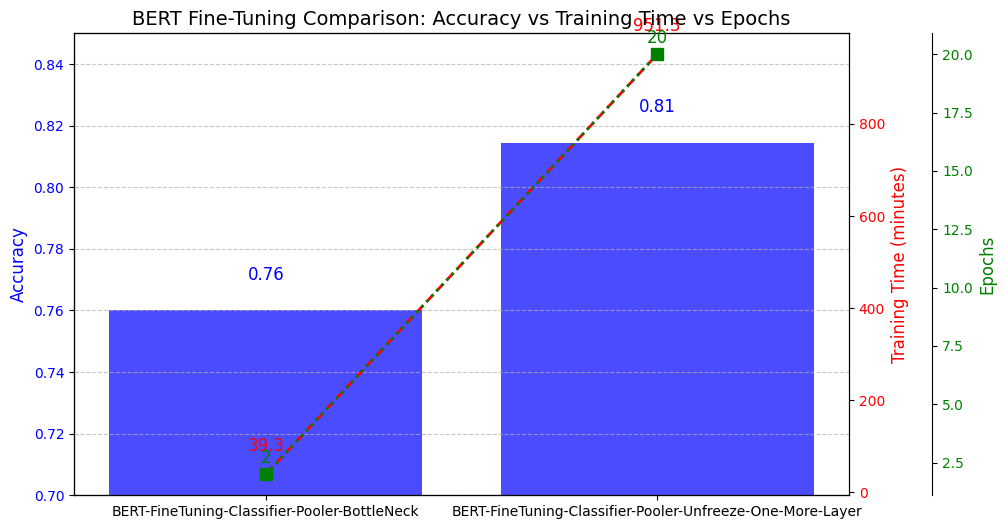

In [57]:
# Create a figure with three subplots: Accuracy, Training Time, Prediction Time and Epochs
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df_results_BERT_FineTuning["Model"], df_results_BERT_FineTuning["Accuracy"], color='b', alpha=0.7, label="Accuracy")
ax1.set_ylabel("Accuracy", color='blue', fontsize=12)
ax1.set_ylim(0.7, 0.85)
ax1.tick_params(axis='y', labelcolor='blue')
for i, v in enumerate(df_results_BERT_FineTuning["Accuracy"]):
    ax1.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12, color='blue')

ax2 = ax1.twinx()
ax2.plot(df_results_BERT_FineTuning["Model"], df_results_BERT_FineTuning["Training Time (minutes)"], color='r', marker='o',  linestyle='dashed', linewidth=2, markersize=8, label="Training Time (min)")
ax2.set_ylabel("Training Time (minutes)", color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
for i, v in enumerate(df_results_BERT_FineTuning["Training Time (minutes)"]):
    ax2.text(i, v + 50, f"{v:.1f}", ha='center', fontsize=12, color='red')


ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df_results_BERT_FineTuning["Model"], df_results_BERT_FineTuning["Epochs"], color='g', marker='s', linestyle='dotted', linewidth=2, markersize=8, label="Epochs")
ax3.set_ylabel("Epochs", color='green', fontsize=12)
ax3.tick_params(axis='y', labelcolor='green')
# Display epoch values on the plot
for i, v in enumerate(df_results_BERT_FineTuning["Epochs"]):
    ax3.text(i, v + 0.5, f"{v}", ha='center', fontsize=12, color='green')

plt.title("BERT Fine-Tuning Comparison: Accuracy vs Training Time vs Epochs", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Fine-Tuning Classifier + Pooler- 2 Epochs**
*  Training Loss: Gradually decreases.
*  Validation Loss: Increases over time → **Possible Overfitting**.
*  Insight: The model might have **underfitted due to limited epoch**s, leading to poor generalization.

**Fine-Tuning Classifier + Pooler + One Encoder Layer - 20 Epochs**

*	Training Loss: Significantly drops, showing effective learning.
* Validation Loss: Initially decreases but **increases again after around 10 epochs**, suggesting **slight overfitting**.
*	Insight: Unfreezing one encoder layer helped learn deeper representations, leading to better performance.

**Accuracy Increased: From 76% → 81.45%** (higher capacity model learned better).

**Training Time Drastically Increased: 39 min → 951 min** (about 24 times longer).


**Key Takeaways:**
* **Fine-tuning more layers improves accuracy.**
* Overfitting Signs in 20 Epoch Model
* **Trade-Off: Drastically increased training time.**
 - If computational resources are limited, this may not be efficient.
   - Stick with only fine-tuning the classifier & pooler layer (2 epochs, 76% accuracy).
   - Try 5-10 epochs instead of full 20 to balance training time vs accuracy
* **If Higher Accuracy is Critical:**
 - Fine-tune 1 more encoder layer with early stopping.
 - Use the 20-epoch model but apply early stopping (stop when validation loss stops improving).
 - Regularization methods (Dropout, Weight Decay, Early Stopping) can help prevent overfitting.
* **For Further Improvement:**
 - Consider fine-tuning more encoder layers gradually, but monitor training time and overfitting.
 - Due to computertatioan source limition on my computer, currently randomly selected 10% of the whole dataset. If time and computational resource are sufficient, using a larger datasize to train the model that might help mitigate overfitting.
 - Experiment with more parameters such as learning rates, batch sizes, and optimizers to improve efficiency and regularization methods to prevent overfitting.


## 12. Results
Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab. Also compare the convergence of the models and the running time. Results should be reported with proper statistical comparisons and proper visualizations.

Here add:

performance - ex. eccuracy, f1 score..

training time

visualizations - loss curves, accuracy plots, confusion matrices

statistical comparisons - t test etc.

Compare the traning time of traning bert with new datsets

In [70]:
oldGPU_traintime_bottleneck_features = 39
GeForce_RTX_4060_traintime_bottleneck_features = 5
OldGPU_traintime_unfree_one_more_layer = 951
GeForce_RTX_4060_unfree_one_more_layer = 60

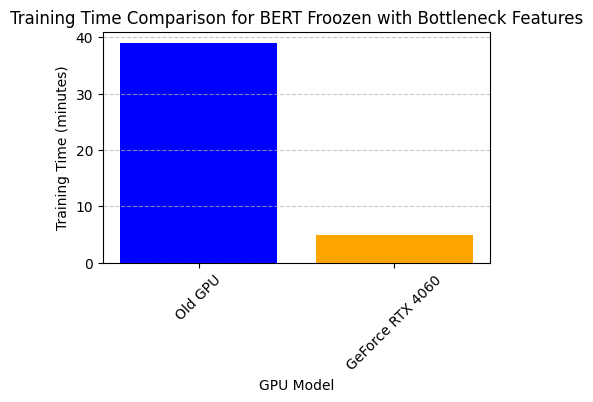

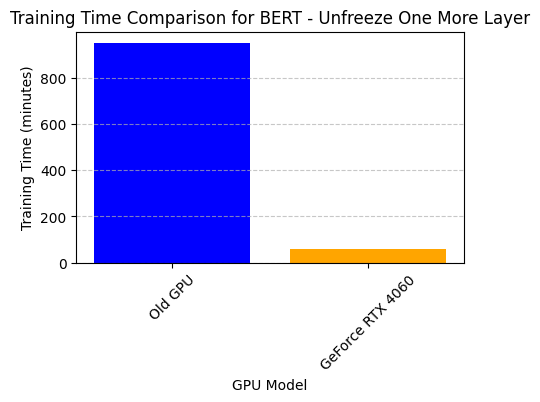

In [79]:
# plot the training time for both models
import matplotlib.pyplot as plt
# Data for plotting
training_times = [oldGPU_traintime_bottleneck_features, GeForce_RTX_4060_traintime_bottleneck_features]
GPUs = ['Old GPU', 'GeForce RTX 4060']
# Create a bar chart
plt.figure(figsize=(5, 3))
plt.bar(GPUs, training_times, color=['blue', 'orange'])
plt.xlabel('GPU Model')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison for BERT Froozen with Bottleneck Features')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


training_times = [OldGPU_traintime_unfree_one_more_layer, GeForce_RTX_4060_unfree_one_more_layer]
GPUs = ['Old GPU', 'GeForce RTX 4060']
# Create a bar chart
plt.figure(figsize=(5, 3))
plt.bar(GPUs, training_times, color=['blue', 'orange'])
plt.xlabel('GPU Model')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison for BERT - Unfreeze One More Layer')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

